<a href="https://colab.research.google.com/github/Andrew1021/CV_SoSe21/blob/main/%C3%9Cbung%201/CV_Uebung_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision SoSe 21
## Übung 3: Image stitching

Projektive Entzerrung mit mehr als 4 Passpunkten, Einbettung in ein gemeinsames Welt-Koordinatensystem, Erzeugung eines Panoramabildes aus mehreren überlappenden Aufnahmen

### Import packets

In [1]:
# Import required packets
if 'google.colab' in str(get_ipython()): #If running in colab 
    import google.colab
    IN_COLAB = True
    import IPython
    if (not IPython.__version__.startswith('5')): # Checking if plt 7.X is installed
        print('Installing IPython version 5.X to run this notebook...')
        !pip install IPython
    from IPython.display import Image
    import PIL
    if (not PIL.__version__.startswith('7')): # Checking if PIL 7.X is installed
        print('Installing pillow version 7.X to run this notebook...')
        !pip install pillow
else:
    IN_COLAB = False

    while True:
        try:
            # pandas and numpy
            import pandas as pd
            import numpy as np

            # matplotlib for showing images
            import matplotlib

            # io for image loading and preprocessing
            import skimage

            # PIL package for predefined affin transformation functions
            import PIL

            # scipy package
            from scipy.ndimage import gaussian_filter

            # tqdm package
            from tqdm import tqdm

        except ModuleNotFoundError as error:
            if (error.name == 'skimage'):
                !pip install scikit-image
            if (error.name == 'tqdm'):
                !pip install tqdm
            else:
                !pip install error.name
        else:
            break

    if (not pd.__version__.startswith('1')): # Checking if pd 1.X is installed
        print('Installing pandas version 1.X to run this notebook...')
        !pip install pandas

    if (not np.__version__.startswith('1')): # Checking if np 1.X is installed
        print('Installing numpy version 1.X to run this notebook...')
        !pip install numpy

    if (not PIL.__version__.startswith('7')): # Checking if PIL 7.X is installed
        print('Installing pillow version 7.X to run this notebook...')
        !pip install pillow

    if (not skimage.__version__.startswith('0')): # Checking if skimage 0.X is installed
        print('Installing scikit-image version 0.X to run this notebook...')
        !pip install scikit-image

    if (not matplotlib.__version__.startswith('3')): # Checking if plt 3.X is installed
        print('Installing matplotlib version 3.X to run this notebook...')
        !pip install matplotlib

    # matplotlib for showing images
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    # io for image loading and preprocessing
    from skimage import data, io, filters

    # PIL package for predefined affin transformation functions
    from PIL import Image

print('Pandas version:',pd.__version__,' Numpy version:',np.__version__, 
      ' Pillow version:',PIL.__version__,' Scikit-image version:',skimage.__version__, 
      ' Matplotlib version:',matplotlib.__version__,' Running in Google Colab?:', IN_COLAB)

Installing pillow version 7.X to run this notebook...
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.
Pandas version: 1.1.4  Numpy version: 1.19.3  Pillow version: 8.0.1  Scikit-image version: 0.18.1  Matplotlib version: 3.3.2  Running in Google Colab?: False


### Load panorama images

In [2]:
# load images from local directory
panorama1 = skimage.io.imread("pan1.jpg")
panorama2 = skimage.io.imread("pan2.jpg")
panorama3 = skimage.io.imread("pan3.jpg")
panorama4 = skimage.io.imread("pan4.jpg")
# convert image pixel values to float
panorama1 = skimage.util.img_as_float(panorama1)
panorama2 = skimage.util.img_as_float(panorama2)
panorama3 = skimage.util.img_as_float(panorama3)
panorama4 = skimage.util.img_as_float(panorama4)

### Transformationmatrices


In [3]:
# Rotation
def get_rotation(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0, 0, 1]
    ])

# Translation
def get_translation(tx, ty):
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

# Scale
def get_scale(sx, sy):
    return np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])

# Shear
def get_shear(sh, sv):
    return np.array([
        [ 1, sh, 0],
        [sv, 1,  0],
        [ 0, 0,  1]
    ])

### a) projective equalization method

In [57]:
def projectiv_transform(image, pp, wc, A, interpolation="bilinear"):
    """
    Python function for projective rectification of images. 
    Passing parameters are the input image, the control points, the world coordinates, 
    the transformation matrix and the interploation type. 
    The return value is the projective rectified output image. 
    The user can choose between nearest-neighbor and bilinear interpolation
    can be selected. 
    All pixels whose initial position lies outside the input image
    are set to 0. 
    The function can process both gray scale and color images.

    :param image: The entrance image, which should be projective tranformed
    :type image: float32
    :param pp: The passpoints
    :type pp: float32
    :param wc: The worldcoordinates
    :type wc: float32
    :param A: The transfromation matrix A for the image transformation
    :type A: float32
    :param interpolation: The interpolation type performed on the image (default bilinear)
    :type interpolation: String

    :return: projective_image: The projective transformed image
    :rtype: float32
    """

    # Input parameters savety checks
    if image.any() == None:
        print("Kein Bild in Variable 'image' übergeben!")
        return -1
    if pp == None or wc == None:
        print("Keine Werte für Passpunkte 'pp' oder Weltkoordinaten 'wc' übergeben!")
        return -1
    if not (len(pp) == len(wc)):
        print("Anzahl der Passpunkte {0} ist ungleich der Anzahl der Weltkoordinaten {1}".format(len(pp),len(wc)))
        return -1
    if A.any() == None:
        print("Keine Werte für Transformationsmatrix 'A' übergeben!")
        return -1
    if (A.any() == None) or not ('naechster-nachbar' or 'bilinear'):
        print("Interpolationsmethode in Variable 'interpolation' muss entweder 'naechster-nachbar' oder 'bilinear' sein!")
        return -1

    # Init matrix and vector
    M = np.zeros([(len(pp)*2),8])
    x_vec = np.zeros([(len(pp)*2),1])

    # Fill homography matrix    
    for i in range(0,((len(pp)*2)-1),2):
        M[i][0] = pp[int(i/2)][0]
        M[i][1] = pp[int(i/2)][1]
        M[i][2] = 1
        M[i][3] = 0
        M[i][4] = 0
        M[i][5] = 0
        M[i][6] = -wc[int(i/2)][0]*pp[int(i/2)][0]
        M[i][7] = -wc[int(i/2)][0]*pp[int(i/2)][1]
        
        M[i+1][0] = 0
        M[i+1][1] = 0
        M[i+1][2] = 0
        M[i+1][3] = pp[int(i/2)][0]
        M[i+1][4] = pp[int(i/2)][1]
        M[i+1][5] = 1
        M[i+1][6] = -wc[int(i/2)][1]*pp[int(i/2)][0]
        M[i+1][7] = -wc[int(i/2)][1]*pp[int(i/2)][1]

    # Fill homography vector             
    for i in range(0,((len(pp)*2)-1),2):
        x_vec[i] = wc[int(i/2)][0]
        x_vec[i+1] = wc[int(i/2)][1]

    # Transpose matrix and calculate eigencalues
    M_trans = np.matrix.transpose(M)
    eigv = np.linalg.eig(np.dot(M_trans, M))[0]

    # calculate a values (later with svd)
    if 0 not in eigv and M.shape[0] == M.shape[1]:
        a_vec = np.dot(np.dot(np.linalg.inv(np.dot(M_trans,M)),M_trans),x_vec) 
    else:
        M_pseu = np.linalg.pinv(M)
        a_vec = np.dot(M_pseu, x_vec)
        
    a1 = a_vec[0]
    a2 = a_vec[1]
    a3 = a_vec[2]
    b1 = a_vec[3]
    b2 = a_vec[4]
    b3 = a_vec[5]
    c1 = a_vec[6]
    c2 = a_vec[7]
        
    
    # check if image has float values otherwise convert to float32 (and normalization)
    #if image.dtype not np.dtype('float32')
    #    image = image.astype("float32")#/image.max()

    # determine original image pixel max values
    rows_original, columns_original, channels_original = image.shape

    # 2x scaling requires at least a tranformation image array 2x the original image
    projective_image = np.zeros((2 * rows_original, 2 * columns_original, channels_original), dtype=np.float)

    # determine new image pixel max values
    rows_new, columns_new, channels_new = projective_image.shape

    ## Centering
    # First thing that must happen is the image must be translated so that 
    # the origin (0, 0) is in the middle of the image. In the case of the 
    # rows x columns image a translation of -rows/2 in the x and -columns/2 y.
    # recenter resultant image
    A_neg = np.array([
    [1, 0, -columns_original/2],
    [0, 1, -rows_original/2],
    [0, 0, 1]])

    # Next another translation matrix needs to be applied which acts to reposition 
    # the spatial domain of the pixels essentially negating the first one that 
    # centered the origin. In this case I need a positive translation of rows in 
    # the x and y where columns comes from twice the original because it has been scaled up by two.
    # center original to 0,0
    A_pos = np.array([
    [1, 0, columns_original],
    [0, 1, rows_original],
    [0, 0, 1]])

    # generate full transformation matrix
    #A = A_pos @ A @ A_neg

    A = A.dot(np.matrix([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))

    # inverting transformation matrix A
    A_inv = np.linalg.inv(A)

    x_max, y_max = image.shape[0] - 1, image.shape[1] - 1

    for row in tqdm(range(0, rows_new)):
        for column in range(0, columns_new):
            
            # input_coords = np.array([row, column, 1])
            # x, y, _ = A_inv @ input_coords

            coord = A_inv.dot([row, column, 1])
            x = coord[0,0]
            y = coord[0,1]

            x_old = ((b2-c2*b3)*x + (a3*c2-a2)*y + a2*b3-a3*b2) / ((b1*c2-b2*c1)*x + (a2*c1-a1*c2)*y + a1*b2-a2*b1)
            y_old = ((b3*c1-b1)*x + (a1-a3*c1)*y + a3*b1-a1*b3) / ((b1*c2-b2*c1)*x + (a2*c1-a1*c2)*y + a1*b2-a2*b1)
            
            if interpolation == "naechster-nachbar":
                x_old = int(np.rint(x_old))
                y_old = int(np.rint(y_old))
                if (0 <= x_old < rows_original) and (0 <= y_old < columns_original):
                    projective_image[row, column, :] = image[y_old, x_old, :]
            else:
                if interpolation == "bilinear":
                    x0 = np.floor(x_old).astype(int)
                    x1 = x0 + 1
                    y0 = np.floor(y_old).astype(int)
                    y1 = y0 + 1
                    if (0 <= x0 < columns_original) and (0 <= y0 < rows_original) and (0 <= x1 < columns_original) and (0 <= y1 < rows_original):
                        P1 = image[y0, x0]
                        P2 = image[y1, x0]
                        P3 = image[y0, x1]
                        P4 = image[y1, x1]
                        A1 = (x1 - x_old) * (y1 - y_old)
                        A2 = (x1 - x_old) * (y_old - y0)
                        A3 = (x_old - x0) * (y1 - y_old)
                        A4 = (x_old - x0) * (y_old - y0)
                        projective_image[row, column, :] = A1*P1 + A2*P2 + A3*P3 + A4*P4

    return projective_image

In [18]:
def weighted(img):
    y_len, x_len, z_len = img.shape
    y_len = y_len -1
    x_len = x_len -1
    
    x_mid = int(x_len/2)
    y_mid = int(y_len/2)
    
    max_dist = np.sqrt(np.square(x_mid)+np.square(y_mid))
    
    new_img = np.zeros(shape = (y_len, x_len,4))
    
    for x in tqdm(range(0, x_len)):
        for y in range(0, y_len):
            curr_dist = np.sqrt(np.square(x-x_mid)+np.square(y-y_mid))
            new_img[y,x] = np.append(img[y,x], [1-(curr_dist/max_dist)])
    return new_img

In [17]:
def calc_weights(img):
    height = img.shape[0]
    width = img.shape[1]

    mx,my = np.meshgrid(np.arange(width),np.arange(height))
    half_size_w = width/2
    half_size_h = height/2

    pw = 1. / half_size_w
    ph = 1. / half_size_h

    hgrid = 1. - ph *abs(half_size_h - my)
    wgrid = 1. - pw *abs(half_size_w - mx)

    weight_matrix = (hgrid * wgrid)
    new_img = np.dstack((img, weight_matrix))
    return new_img

### c) Merge images to panorama

In [14]:
def merge(left_img, right_img, method):
    
    y_len_left, x_len_left, z_len_left = left_img.shape
    y_len_right, x_len_right, z_len_right = right_img.shape

    rows = np.maximum(y_len_left, y_len_right)
    columns = np.maximum(x_len_left, x_len_right)
    channels = np.maximum(z_len_left, z_len_right)
    # 2x scaling requires at least a tranformation image array 2x the original image
    new_img = np.zeros((2 * rows, 2 * columns, channels), dtype=np.float)
    y_new_len, x_new_len, z_new_len = new_img.shape
    
    new_img[0:left_img.shape[0], 0:left_img.shape[1]] = left_img

    if method == "multi-band blending":
        left_lp = gaussian_filter(left_img, sigma = 5)
        right_lp = gaussian_filter(right_img, sigma = 5)
        left_hp = left_img - left_lp
        right_hp = right_img - right_lp
            
    for x in tqdm(range(0, x_new_len)):
        for y in range(0, y_new_len):
            if x > x_len_right-1:
                break
            if method == "Groesseres Gewicht":
                if x > x_len_left-1 or right_img[y,x,3] > left_img[y,x,3]:
                    new_img[y,x,:] = right_img[y,x, :]
            if method == "Gewichteter Mittelwert":
                if x > x_len_left-1:
                    new_img[y,x,:] = right_img[y,x, :]
                else:
                    new_img[y,x,:] = (right_img[y,x,3] * right_img[y,x,:] + left_img[y,x,3] * left_img[y,x,:])/(right_img[y,x,3]+left_img[y,x,3]+10e-5)
            if method == "multi-band blending":
                if x > x_len_left-1:
                    new_img[y,x,:] = right_img[y,x, :]
                else:
                    if right_img[y,x,3] > left_img[y,x,3]:
                        higher_hp = right_hp[y,x,:]
                    else:
                        higher_hp = left_hp[y,x,:]
                    new_img[y,x,:] = ((right_img[y,x,3] * right_lp[y,x,:] + left_img[y,x,3] * left_lp[y,x,:])/(right_img[y,x,3]+left_img[y,x,3]+10e-5)) + higher_hp
    return new_img

### Show images

Text(0.5, 1.0, 'Abb. 4: Panorama 4')

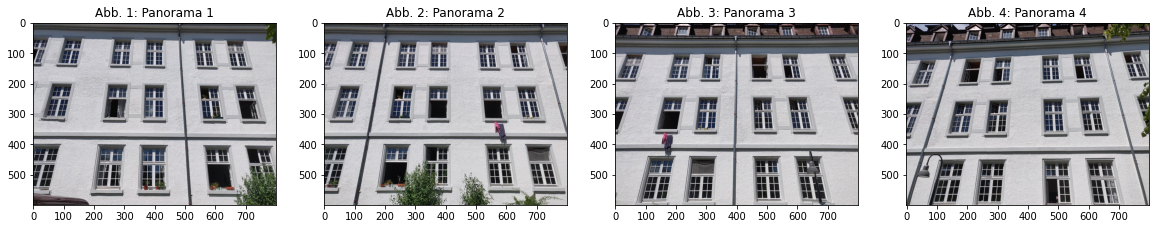

In [56]:
# show all four images
plt.figure(figsize=(20, 20))

plt.subplot(1, 4, (1))
plt.imshow(panorama1)
plt.title("Abb. 1: Panorama 1")

plt.subplot(1, 4, (2))
plt.imshow(panorama2)
plt.title("Abb. 2: Panorama 2")

plt.subplot(1, 4, (3))
plt.imshow(panorama3)
plt.title("Abb. 3: Panorama 3")

plt.subplot(1, 4, (4))
plt.imshow(panorama4)
plt.title("Abb. 4: Panorama 4")

### Show center weighted images

In [20]:
# calculate center weight of images
panorama_center1 = calc_weights(panorama1)
panorama_center2 = calc_weights(panorama2)
panorama_center3 = calc_weights(panorama3)
panorama_center4 = calc_weights(panorama4)

Text(0.5, 1.0, 'Abb. 4: Panorama centered 4')

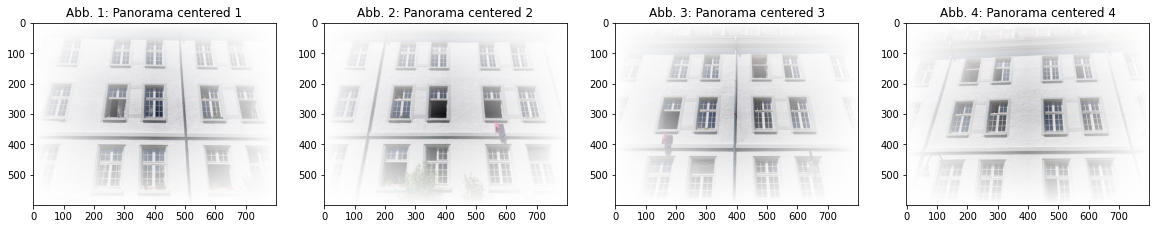

In [23]:
# show all four images
plt.figure(figsize=(20, 20))

plt.subplot(1, 4, (1))
plt.imshow(panorama_center1)
plt.title("Abb. 1: Panorama centered 1")

plt.subplot(1, 4, (2))
plt.imshow(panorama_center2)
plt.title("Abb. 2: Panorama centered 2")

plt.subplot(1, 4, (3))
plt.imshow(panorama_center3)
plt.title("Abb. 3: Panorama centered 3")

plt.subplot(1, 4, (4))
plt.imshow(panorama_center4)
plt.title("Abb. 4: Panorama centered 4")

### Passpoints and Worldcoordinates

In [24]:
## Passpoints Image 1:

# Passpoints window left
p1 = [238,194] # top left
p2 = [321,195] # top right
p3 = [312,324] # bottom right
p4 = [221,323] # bottom left

# Passpoints window right
p5 = [538,198] # top left
p6 = [620,199] # top right
p7 = [641,327] # bottom right
p8 = [552,326] # bottom left

pp1 = [p1,p2,p3,p4,p5,p6,p7,p8]

# worldcoordinates window left
w1 = [0,0]  # bottom left
w2 = [152,0] # bottom right
w3 = [152,242]  # top right
w4 = [0,242] # top left

# worldcoordinates window right
w5 = [543,0]  # bottom left
w6 = [696,0] # bottom right
w7 = [696,242]  # top right
w8 = [543,242] # top left
# Points in the Picture
wc1 = [w1,w2,w3,w4,w5,w6,w7,w8]

print("Passpoints ({0}): {1}".format(len(pp1),pp1))
print("Worldcoordinates ({0}): {1}".format(len(wc1),wc1))

Passpoints (8): [[238, 194], [321, 195], [312, 324], [221, 323], [538, 198], [620, 199], [641, 327], [552, 326]]
Worldcoordinates (8): [[0, 0], [152, 0], [152, 242], [0, 242], [543, 0], [696, 0], [696, 242], [543, 242]]


In [25]:
## Passpoints Image 2:

# Passpoints window left
p1 = [222,201] # Oben links
p2 = [301,200] # Oben rechts
p3 = [292,325] # Unten rechts
p4 = [205,325] # Unten links

#Passpunkte Fenster rechts
p5 = [512,202] # Oben links
p6 = [589,205] # Oben rechts
p7 = [608,325] # Unten rechts
p8 = [522,325] # Unten links

pp2 = [p1,p2,p3,p4,p5,p6,p7,p8]

#Weltkoordinaten
w1 = [543,0]  # oben links
w2 = [696,0] # oben rechts
w3 = [696,242]  # unten rechts
w4 = [543,242] # unten links

w5 = [1113,0]  # oben links
w6 = [1265,0] # oben rechts
w7 = [1265,242]  # unten rechts
w8 = [1113,242] # unten links

wc2 = [w1,w2,w3,w4,w5,w6,w7,w8]

print("Passpoints ({0}): {1}".format(len(pp2),pp2))
print("Worldcoordinates ({0}): {1}".format(len(wc2),wc2))

Passpoints (8): [[222, 201], [301, 200], [292, 325], [205, 325], [512, 202], [589, 205], [608, 325], [522, 325]]
Worldcoordinates (8): [[543, 0], [696, 0], [696, 242], [543, 242], [1113, 0], [1265, 0], [1265, 242], [1113, 242]]


In [26]:
## Passpoints Image 3:

#Passpunkte Fenster links
p1 = [154,238] # Oben links
p2 = [232,238] # Oben rechts
p3 = [212,362] # Unten rechts
p4 = [124,362] # Unten links
#Passpunkte Fenster rechts
p5 = [445,238] # Oben links
p6 = [525,238] # Oben rechts
p7 = [538,362] # Unten rechts
p8 = [449,362] # Unten links

pp3 = [p1,p2,p3,p4,p5,p6,p7,p8]

#Weltkoordinaten
w1 = [1113,0]  # oben links
w2 = [1265,0] # oben rechts
w3 = [1265,242]  # unten rechts
w4 = [1113,242] # unten links

w5 = [1683,0]  # oben links
w6 = [1835,0] # oben rechts
w7 = [1835,242]  # unten rechts
w8 = [1683,242] # unten links

wc3 = [w1,w2,w3,w4,w5,w6,w7,w8]

print("Passpoints ({0}): {1}".format(len(pp3),pp3))
print("Worldcoordinates ({0}): {1}".format(len(wc3),wc3))

Passpoints (8): [[154, 238], [232, 238], [212, 362], [124, 362], [445, 238], [525, 238], [538, 362], [449, 362]]
Worldcoordinates (8): [[1113, 0], [1265, 0], [1265, 242], [1113, 242], [1683, 0], [1835, 0], [1835, 242], [1683, 242]]


In [27]:
## Passpoints Image 4:

#Passpunkte Fenster links
p1 = [156,252] # Oben links
p2 = [232,250] # Oben rechts
p3 = [210,374] # Unten rechts
p4 = [126,375] # Unten links
#Passpunkte Fenster rechts
p5 = [443,245] # Oben links
p6 = [524,243] # Oben rechts
p7 = [537,370] # Unten rechts
p8 = [445,371] # Unten links

pp4 = [p1,p2,p3,p4,p5,p6,p7,p8]

#Weltkoordinaten
w1 = [1683,0]  # oben links
w2 = [1835,0] # oben rechts
w3 = [1835,242]  # unten rechts
w4 = [1683,242] # unten links

w5 = [2253,0]  # oben links
w6 = [2405,0] # oben rechts
w7 = [2405,242]  # unten rechts
w8 = [2253,242] # unten links

wc4 = [w1,w2,w3,w4,w5,w6,w7,w8]

print("Passpoints ({0}): {1}".format(len(pp4),pp4))
print("Worldcoordinates ({0}): {1}".format(len(wc4),wc4))

Passpoints (8): [[156, 252], [232, 250], [210, 374], [126, 375], [443, 245], [524, 243], [537, 370], [445, 371]]
Worldcoordinates (8): [[1683, 0], [1835, 0], [1835, 242], [1683, 242], [2253, 0], [2405, 0], [2405, 242], [2253, 242]]


### projective equalization

In [28]:
# If needed generate transfromation matrix (homography)
# Rotation
R = get_rotation(0)
# Translation
T = get_translation(0, 0)
# Scale
SC = get_scale(1, 1)
# Shear
SH = get_shear(0, 0)
A = R @ T @ SC @ SH

In [58]:
panorama_cprojective1 = projectiv_transform(panorama_center1, pp1, wc1, A, interpolation="bilinear")
panorama_cprojective2 = projectiv_transform(panorama_center2, pp2, wc2, A, interpolation="bilinear")
panorama_cprojective3 = projectiv_transform(panorama_center3, pp3, wc3, A, interpolation="bilinear")
panorama_cprojective4 = projectiv_transform(panorama_center4, pp4, wc4, A, interpolation="bilinear")

100%|██████████| 1200/1200 [03:04<00:00,  6.50it/s]


In [59]:
panorama_projective1 = projectiv_transform(panorama1, pp1, wc1, A, interpolation="bilinear")
panorama_projective2 = projectiv_transform(panorama2, pp2, wc2, A, interpolation="bilinear")
panorama_projective3 = projectiv_transform(panorama3, pp3, wc3, A, interpolation="bilinear")
panorama_projective4 = projectiv_transform(panorama4, pp4, wc4, A, interpolation="bilinear")

100%|██████████| 1200/1200 [02:44<00:00,  7.29it/s]


### Merge images to one panorama

In [60]:
# center weighted panorama
panorama_cprojective12 = merge(panorama_cprojective1, panorama_cprojective2, "multi-band blending")
panorama_cprojective34 = merge(panorama_cprojective3, panorama_cprojective4, "multi-band blending")
panorama_cprojective = merge(panorama_cprojective12, panorama_cprojective34, "multi-band blending")

NameError: name 'img_new' is not defined

In [ ]:
# panorama
panorama12 = merge(panorama_projective1, panorama_projective2, "multi-band blending")
panorama34 = merge(panorama_projective3, panorama_projective4, "multi-band blending")
panorama = merge(panorama12, panorama34, "multi-band blending")

In [ ]:
# show panorama
plt.figure(figsize=(20, 20))

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Panorama')

ax1.imshow(panorama_center1)
ax1.title("Abb. 1: Panorama centered")

ax2.imshow(panorama_center2)
ax2.title("Abb. 2: Panorama normal")